In [1]:
import numpy as np
import uproot

import matplotlib.pyplot as plt
import seaborn as sn

from lmfit import Model

In [2]:
def pos_r(x, y, z):
    #function to recompute the radius of events due to the posz correction given the x, y and z position
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

In [3]:
file = uproot.open('/snoplus simulations/alpha_n/ScintFit_2p2Alphan_Lab_13cRun_r300000_s0_p2.ntuple.root')
file.keys()

['output;1', 'meta;1']

In [4]:
output = file['output;1']

# 1 - Extract useful variables

In [5]:
#validation info
scint_fit = np.array(output['scintFit'])

#event Index
evIndex = np.array(output['evIndex'])  #evIndex = 0 is prompt, and evIndex > 0 is delayed and tails of prompt and delayed

#recons. energy
energy = np.array(output['energy'])

#recons. position
posx = np.array(output['posx'])
posy = np.array(output['posy'])
posz = np.array(output['posz']) - 184.4
posr = pos_r(posx, posy, posz)

#MC info
mcID = np.array(output['mcIndex'])
mc_posx = np.array(output['mcPosx'])
mc_posy = np.array(output['mcPosy'])
mc_posz = np.array(output['mcPosz'])
mc_posr = np.array(output['mcPosr'])

# Time info
clock_count50 = np.array(output['clockCount50'], dtype = np.int64)

#ev info
evID = np.array(output['eventID'])
nhits = np.array(output['nhits'])

# Extract valid info -> Valid scint_fit -------------

evIndex = np.extract(scint_fit, evIndex)

mc_posx = np.extract(scint_fit, mc_posx)
mc_posy = np.extract(scint_fit, mc_posy)
mc_posz = np.extract(scint_fit, mc_posz)

posx = np.extract(scint_fit, posx)
posy = np.extract(scint_fit, posy)
posz = np.extract(scint_fit, posz)
posr = np.extract(scint_fit, posr)

time = np.extract(scint_fit, (clock_count50*20)/1000)  #convert ns to μs

evID = np.extract(scint_fit, evID)

energy = np.extract(scint_fit, energy)

# 2 - Procedure to Select the Correct Pairs of prompt and Delayed with cuts

In [6]:
#Cuts ----------------
energy_cut = 0.5
radial_cut = 5500
#---------------------

# Look for the indices of the array elements that verifies evIndex 0 and 2. Guarant that we dont have the same consecutive values of evIndex, and then extract the correct indices of array elements
# for then extract the observables of interest.

ev_index_condition = (evIndex == 0) | (evIndex == 2)

filter_index = np.where(ev_index_condition)[0]  # Indices which verifies the evIndex condition. Useful to look for the energy, time, and position of the desired prompt and delayed

test_evindex = evIndex[filter_index]  #This shows that even when we select the evIndex 0 and 2, there are consecutive records with 0 and 2. Lets remove this consecutive values following the rules:
                                     #1) if there is zero in i and i+1 indices, remove the i. 2) if there is twos in i and i+1, remove i+1.

index_to_del = []  #list of indicies of elements to be removed in filter_index. This is used to correct the filter_index list.

for i in range(len(test_evindex)-1):
    if test_evindex[i] == 0 and test_evindex[i+1] == 0:
        index_to_del.append(i)
    if test_evindex[i] == 2 and test_evindex[i+1] == 2:
        index_to_del.append(i+1)

filter_index = np.delete(filter_index, index_to_del)  #cleaning of the filter_index list

# Extract observables and Arange by pairs of prompt and delayed. If there is an error due to non-equal division, then set a condition for the filter_index:
evindex_filter = evIndex[filter_index].reshape((-1,2))
energy_filter = energy[filter_index].reshape((-1,2))
posr_filter = posr[filter_index].reshape((-1,2))
posx_filter = posx[filter_index].reshape((-1,2))
posy_filter = posy[filter_index].reshape((-1,2))
posz_filter = posz[filter_index].reshape((-1,2))
time_filter = time[filter_index].reshape((-1,2))

#Energy and radial cut
cut_condition = (energy_filter >= energy_cut) & (posr_filter <= radial_cut)

mask = np.all(cut_condition, axis = 1)  #evaluates where all the elements of axis 1 (rows) are True

#cut values of energy and postions
energy_cut = energy_filter[mask]
posr_cut = posr_filter[mask]
posx_cut = posx_filter[mask]
posy_cut = posy_filter[mask]
posz_cut = posz_filter[mask]
time_cut = time_filter[mask]

#extract the information of prompt and delayed
#Compute Delta time
t0 = time_cut[:,0]
t1 = time_cut[:,1]
Dt = t1 - t0

#Compute Delta r
posx_0 = posx_cut[:,0]
posy_0 = posy_cut[:,0]
posz_0 = posz_cut[:,0]

posx_1 = posx_cut[:,1]
posy_1 = posy_cut[:,1]
posz_1 = posz_cut[:,1]

dx = posx_1 - posx_0
dy = posy_1 - posy_0
dz = posz_1 - posz_0

Dr = np.sqrt((dx**2) + (dy**2) + (dz**2))

# 3 - Proceed with the Exponential fit

## *Fit funtion

In [7]:
def fit_exp(x, n0, lambda_):
    return n0 * np.exp(lambda_ * x)

## 3.1 - Extract the Data Points

In [20]:
bins_t = 20

counts, bins_edge = np.histogram(Dt, bins = bins_t)

#Counts are y-axis values and bins_center are x_axis values
bins_center = (bins_edge[:-1] + bins_edge[1:]) / 2
bins_center = np.round(bins_center, decimals = 2)

## 3.2 - Perform the fit

In [45]:
y = counts
x = bins_center

fit_model = Model(fit_exp)
result = fit_model.fit(y, x=x, n0 = 1, lambda_ = 1/150)

n0 = result.best_values['n0']
lambda_ = result.best_values['lambda_']

lambda_err = result.params['lambda_'].stderr
n0_err = result.params['n0'].stderr

tau = -1/lambda_
tau_err = lambda_err/(lambda_**2)  #error propagation
tau 

print(result.fit_report())

[[Model]]
    Model(fit_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 20
    # variables        = 2
    chi-square         = 557.141649
    reduced chi-square = 30.9523138
    Akaike info crit   = 70.5417448
    Bayesian info crit = 72.5332094
    R-squared          = 0.99016797
[[Variables]]
    n0:       233.021010 +/- 6.47413665 (2.78%) (init = 1)
    lambda_: -0.00476106 +/- 1.8473e-04 (3.88%) (init = 0.006666667)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, lambda_) = -0.7268


In [23]:
tau

210.0370524416727

In [36]:
tau_err

8.149386661677505

In [48]:
n0

233.0

In [46]:
n0_err

6.474136651961788

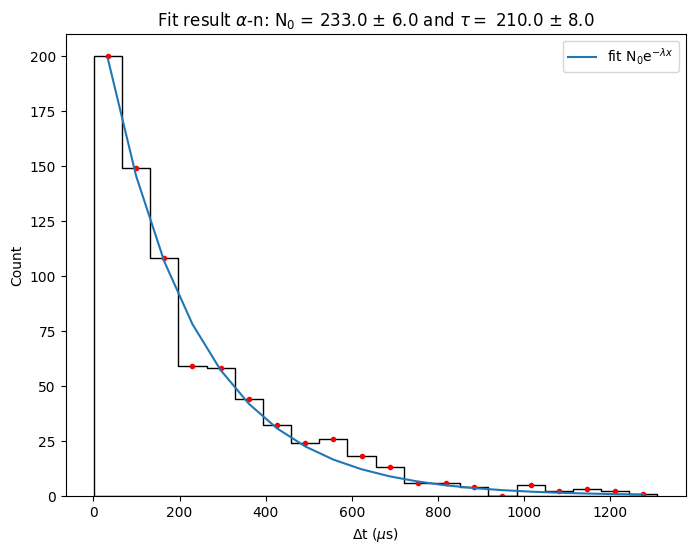

In [49]:
tau = np.round(tau, 0)
tau_err = np.round(tau_err, 0)

n0 = np.round(n0, 0)
n0_err = np.round(n0_err, 0)

save_fig = True

plt.figure(figsize=(8,6))

sn.histplot(Dt, bins = bins_t, color = 'black', alpha = 0.0, element = 'step')
plt.scatter(x = bins_center, y =counts, color = 'r', marker='.')
plt.plot(x, result.best_fit, label = r'fit N$_0$e$^{-\lambda x}$')
plt.legend(loc = 'upper right')
plt.xlabel(r'$\Delta$t ($\mu$s)')
plt.title(r'Fit result $\alpha$-n: N$_0$ = {n0_} $\pm$ {n0_err_} and $τ = $ {tau_} $\pm$ {tau_err_}'.format(n0_=n0, n0_err_ = n0_err, tau_ = tau, tau_err_ = tau_err))

if save_fig:
    plt.savefig('figs/exp_fit_to_delta_t.png', format='png', bbox_inches = 'tight')

plt.show()